# Downloads raw data

In [1]:
import API.send_request as req
import json

# match information
match_id = 'EUW1_5531763758'
server = 'europe'
api_key = 'RGAPI-2657eeab-5b3c-4d82-9e45-9d025e676d7a'
save_path = '../../Dataset/League_of_Legends/challenger_raw/'

sender = req.match_req_sender(server, api_key)
meta = sender.req_match(match_id)
timeline = sender.req_timeline(match_id)

if (meta != None and timeline != None):
    meta = meta.json()
    timeline = timeline.json()

    # save json file
    with open(save_path+f"{match_id}.json", "w") as file_match:
        json.dump(meta, file_match, indent=4)

    with open(save_path+f"{match_id}_timeline.json", "w") as file_timeline:
        json.dump(timeline, file_timeline, indent=4)

Got match data with match id=EUW1_5531763758 successfuly.
Got timeline data with match id=EUW1_5531763758 successfuly.


# Extract features

In [2]:
import pandas as pd
from os import listdir
from tqdm import tqdm
from torch import tensor, zeros

pickle_route = "../../Dataset/League_of_Legends/features_tensor/challenger/"

print("Processing flipped train features...")
csv_route = "../../Dataset/League_of_Legends/challenger_csv/"
feat_list = listdir(csv_route)

for file_name in tqdm(feat_list):
    file = pd.read_csv(f"{csv_route}{file_name}")
    file = file.sort_values(by='time', ascending=False, axis=0, ignore_index=True)
    file = file[file['is_valid'] == True]
    file = file.loc[:,"time":"event_weight"]
    players = []
    for idx in range(0, 10):
        player = file[file["player"] == idx+1].drop(columns=["player"])
        temp_feature = tensor([player.values]) if len(player) != 0 else zeros([1, 1, 30])
        # if temp_feature.size()[1] > 1: temp_feature = temp_feature.flip(1)
        players.append(temp_feature)
    pd.to_pickle(players, f"{pickle_route}{file_name[0:-4]}.pkl")
print("")

Processing flipped train features...


100%|██████████| 13/13 [00:00<00:00, 57.23it/s]

# Test


In [3]:
import pasta_spaghettini as spa
from tqdm import tqdm
import pandas as pd

hp = {"epochs": 1, "learning_rate": 0.01, "num_layers": 1, "hidden_size": 8, "input_size": 30}
PASTA = spa.PASTA(hp["input_size"], hp["hidden_size"], hp["num_layers"], hp["learning_rate"])

route = "../../Dataset/League_of_Legends/features_tensor/challenger/"

test_match_result_ftr = pd.read_csv("./processed_csvs/challenger_result.csv")
total_rows = test_match_result_ftr.shape[0]

PASTA.load_parameter(postfix="_spaghettini")
confusion_matrix, c_label = [0, 0, 0, 0], ["TN", "FP", "FN", "TP"]

print("--test start--")
for idx, row in tqdm(test_match_result_ftr.iterrows(), ncols=50, total=total_rows):
    match_id, win = row["match_no"], row["win"]
    features = pd.read_pickle(f"{route}{match_id}.pkl")
    winner, predict = PASTA.test(features, win, match_id, postfix="challenger")
    correct = 2*winner + predict
    confusion_matrix[correct] += 1

for idx in range(0, 4):
    print(f"{c_label[idx]}: {confusion_matrix[idx]} / ", end="")

--test start--


100%|█████████████| 13/13 [00:00<00:00, 64.69it/s]

TN: 9 / FP: 0 / FN: 0 / TP: 4 / 

# Score analysis

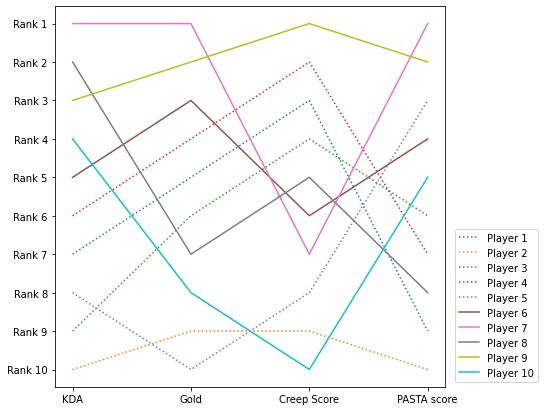

In [1]:
import experiment_vis_leaderboard as lb
import matplotlib.pyplot as plt

match = 'KR_5531638748' # Plaayer 5: Not very good according to traditional indicators, but PASTA score is high
# match = 'NA1_4083949961' # Player 8: Performed well according to traditional indicators, but PASTA score is low
# match = 'EUW1_5531763758'

data, isWin = lb.load_leaderboard_graph(match, challenger=True)

players = []
for index, series in data.iterrows():
    ranks = series.tolist()
    ranks = [11-rank for rank in ranks]
    players.append(ranks)

x_axis = data.columns.tolist()

fig = plt.figure(figsize=(7, 7))

##### total plot #####
for i in range(len(players)):
    line = '-' if isWin[i] else ':'
    plt.plot(x_axis, players[i], linestyle=line, label=f'Player {i+1}')
plt.yticks([i+1 for i in range(10)], [f'Rank {10-i}' for i in range(10)])
plt.legend(bbox_to_anchor=(0.5, 0, 0.75, 0), loc='lower right')
    
plt.show()

In [1]:
import experiment_vis_leaderboard as lb
import matplotlib.pyplot as plt

match = 'NA1_4083949961'

data = lb.load_leaderboard(match, challenger=True)
data.drop(labels='sum of ranks', axis='columns', inplace=True)
data = data[['KDA', 'Gold Earn & Spend', 'totalMinionsKilled', 'total score']]
data

,KDA,Gold Earn & Spend,totalMinionsKilled,total score
Rank 1,Player 8,Player 8,Player 9,Player 9
Rank 2,Player 10,Player 9,Player 1,Player 10
Rank 3,Player 9,Player 1,Player 6,Player 6
Rank 4,Player 3,Player 2,Player 4,Player 5
Rank 5,Player 6,Player 6,Player 3,Player 1
Rank 6,Player 7,Player 4,Player 8,Player 2
Rank 7,Player 2,Player 3,Player 2,Player 8
Rank 8,Player 5,Player 7,Player 7,Player 4
Rank 9,Player 1,Player 10,Player 5,Player 7
Rank 10,Player 4,Player 5,Player 10,Player 3


# Scores per events of a player

In [2]:
import pandas as pd

pd.set_option("display.max_rows", None, "display.max_columns", None)
events = ['ITEM_PURCHASED', 'ITEM_SOLD',
       'ITEM_DESTROYED', 'SKILL_LEVEL_UP', 'LEVEL_UP', 'WARD_PLACED',
       'WARD_KILL', 'CHAMPION_KILL', 'CHAMPION_KILL_ASSIST',
       'CHAMPION_KILL_VICTIM', 'BUILDING_KILL', 'BUILDING_KILL_ASSIST',
       'ELITE_MONSTER_KILL', 'ELITE_MONSTER_KILL_ASSIST']

match_id = 'NA1_4083949961'
data = pd.read_csv('./processed_ftr/scores_challenger.csv')

data = data[(data['match_id'] == match_id) & (data['player'] == 7)].drop(labels=['match_id', 'win'], axis='columns')
data = data.drop(labels=['mage', 'fighter', 'support', 'tank', 'assassin', 'marksman', 'TOP', 'MIDDLE', 'BOTTOM', 'JUNGLE', 'UTILITY'], axis='columns')

scoresums, counts, means = [], [], []
for event in events:
    event_scores = data[data[event] == 1]['score'].tolist()
    
    _sum = sum(event_scores)
    _count = len(event_scores)
    _mean = _sum / _count if _count != 0 else 0
    
    scoresums.append(_sum)
    counts.append(_count)
    means.append(_mean)
    
scoresum_per_event = {
    'event': events, 'sum of score': scoresums, 'count': counts, 'mean': means
}
scoresum_per_event = pd.DataFrame(scoresum_per_event).sort_values(by='sum of score', axis=0, ascending=False, ignore_index=True)
scoresum_per_event

,event,sum of score,count,mean
0,LEVEL_UP,18.066635,17,1.062743
1,SKILL_LEVEL_UP,16.399593,18,0.911088
2,ITEM_PURCHASED,7.560416,31,0.243884
3,CHAMPION_KILL,7.355309,17,0.432665
4,WARD_PLACED,4.377531,19,0.230396
5,ITEM_DESTROYED,3.966744,17,0.233338
6,CHAMPION_KILL_VICTIM,3.020951,7,0.431564
7,CHAMPION_KILL_ASSIST,2.290555,10,0.229055
8,BUILDING_KILL,2.029260,2,1.014630
9,WARD_KILL,1.890446,8,0.236306


# Average scores per player for a event

In [4]:
import pandas as pd

pd.set_option("display.max_rows", None, "display.max_columns", None)

match_id = 'NA1_4083949961'
data = pd.read_csv('./processed_ftr/scores_challenger.csv')

data = data[(data['match_id'] == match_id)].drop(labels=['match_id', 'win'], axis='columns')
data = data.drop(labels=['mage', 'fighter', 'support', 'tank', 'assassin', 'marksman', 'TOP', 'MIDDLE', 'BOTTOM', 'JUNGLE', 'UTILITY'], axis='columns')

scoresums, counts, means = [], [], []
data = data[data['CHAMPION_KILL'] == 1]
for player in range(10):
    event_scores = data[data['player'] == player]['score'].tolist()
    
    _sum = sum(event_scores)
    _count = len(event_scores)
    _mean = _sum / _count if _count != 0 else 0
    
    scoresums.append(_sum)
    counts.append(_count)
    means.append(_mean)
    
scoresum_per_event = {
    'player': [i+1 for i in range(10)], 'sum of score': scoresums, 'count': counts, 'mean': means
}
scoresum_per_event = pd.DataFrame(scoresum_per_event).sort_values(by='player', axis=0, ascending=True, ignore_index=True)
scoresum_per_event

,player,sum of score,count,mean
0,1,8.032708,13,0.617901
1,2,6.407672,13,0.492898
2,3,2.493614,5,0.498723
3,4,2.565812,5,0.513162
4,5,0.633114,2,0.316557
5,6,6.054325,8,0.756791
6,7,1.716324,5,0.343265
7,8,7.355309,17,0.432665
8,9,10.981419,16,0.686339
9,10,0.526509,1,0.526509


# Event sequence of a player

In [5]:
import pandas as pd

pd.set_option("display.max_rows", None, "display.max_columns", None)
events = ['ITEM_PURCHASED', 'ITEM_SOLD',
       'ITEM_DESTROYED', 'SKILL_LEVEL_UP', 'LEVEL_UP', 'WARD_PLACED',
       'WARD_KILL', 'CHAMPION_KILL', 'CHAMPION_KILL_ASSIST',
       'CHAMPION_KILL_VICTIM', 'BUILDING_KILL', 'BUILDING_KILL_ASSIST',
       'ELITE_MONSTER_KILL', 'ELITE_MONSTER_KILL_ASSIST']

match_id = 'NA1_4083949961'

data = pd.read_csv('./processed_ftr/scores_challenger.csv')
data = data[(data['match_id'] == match_id) & (data['player'] == 7)]
data.sort_values(by='time', inplace=True, ignore_index=True)

event_seq = []
for i in range(data.shape[0]):
    seq = {
        'time': data.loc[i, 'time'],
        'score': data.loc[i, 'score']
    }
    for event in events:
        if data.loc[i, event] == 1: seq['event'] = event
    event_seq.append(seq)

event_seq = pd.DataFrame(event_seq)
event_seq

,time,score,event
0,0.002348,0.228728,ITEM_PURCHASED
1,0.002515,0.346316,ITEM_PURCHASED
2,0.034066,1.295702,SKILL_LEVEL_UP
3,0.048727,1.292579,LEVEL_UP
4,0.049049,1.171073,SKILL_LEVEL_UP
5,0.054874,0.307536,WARD_PLACED
6,0.062062,1.293000,LEVEL_UP
7,0.062756,1.101252,SKILL_LEVEL_UP
8,0.068531,0.348071,ITEM_PURCHASED
9,0.089154,1.286241,LEVEL_UP
